# Notebook used during the research
##### (Scripts from this notebook were cleaned up and organized, and are available in the "Scripts" folder)

In [3]:
import os
from PIL import Image
import csv

# Function to extract metadata from an image
def extract_image_metadata(image_path):
    try:
        with Image.open(image_path) as img:
            metadata = {
                "ISO": img._getexif().get(34855),  # ISO
                "ShutterSpeed": img._getexif().get(33434),  # Shutter Speed
                "FocalLength": img._getexif().get(37386),  # Focal Length
                "FStop": img._getexif().get(33437),  # F-Stop
                "WhiteBalance": img._getexif().get(41987)  # White Balance
            }
            return metadata
    except (AttributeError, FileNotFoundError, IsADirectoryError, PermissionError):
        return None

# Folder containing the images
image_folder = "/home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/IndividualCollections/2024-2-26"

# Output CSV file
csv_file = "output.csv"

# Get a list of image files in the folder
image_files = [file for file in os.listdir(image_folder) if file.lower().endswith(('jpg', 'jpeg', 'png', 'gif', 'bmp'))]

# Prepare the CSV header and rows
header = ["Image Name", "Site", "Substrate", "Auto", "ISO", "ShutterSpeed", "FocalLength", "FStop", "WhiteBalance", "FNU", "DOC", "Flow", "Secchi", "TSS"]
rows = []

# Iterate through image files and extract metadata
for image_name in image_files:
    image_path = os.path.join(image_folder, image_name)
    metadata = extract_image_metadata(image_path)

    # Append a row for each image
    rows.append([image_name, "", "", "", metadata["ISO"] if metadata else "", metadata["ShutterSpeed"] if metadata else "",
                 metadata["FocalLength"] if metadata else "", metadata["FStop"] if metadata else "",
                 metadata["WhiteBalance"] if metadata else "", "", "", "", "", ""])

# Write to CSV
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(header)
    writer.writerows(rows)

print("CSV file created successfully:", csv_file)


CSV file created successfully: output.csv


# Make sure to add values and tidy up the csv in excel, and also rename

### Code for splitting all pictures in a master dataset folder into range folders

#### Old Ranges (unweighted)

In [3]:
# 5 categories
folder_ranges = [(0, 10), (11, 21), (22, 32), (33, 43), (44, 55)]

In [ ]:
# 11 categories
folder_ranges = [(0, 5), (6, 10), (11, 15), (16, 20), (21, 25), (26,30), (31,35), (36,40), (41,45), (46,50), (51,55)]

#### Use Weighted

In [1]:
# 11 categories weighted
folder_ranges = [(0, 0.49), (0.5, 0.99), (1, 2.49), (2.5, 4.99), (5, 9.99), (10,14.99), (15,20.99), (21,28.99), (29,36.99), (37,44.99), (45,55)]


In [8]:
# 8 categories weighted
folder_ranges = [(0, 0.49), (0.5, 0.99), (1, 2.99), (3,6.99), (7,15.99), (16,26.99),(27,39.99),(40,55)]

In [18]:
# 5 categories (weighted)
folder_ranges = [(0, 0.99), (1, 4), (5, 9), (10, 24), (25, 55)]

In [2]:
# Input CSV file
csv_file ="./Datasets/Combined/_Master-Combined.csv"

In [3]:
# Specify the parent directory where you want to create the folders
parent_directory = "./Datasets/Combined/temp/"

In [4]:
# Specify path to input folder of images
image_folder = "./Datasets/Combined/_Master/"

In [5]:
import os
import shutil
import csv


for start, end in folder_ranges:
    folder_name = f"{start}-{end}"
    os.makedirs(os.path.join(parent_directory, folder_name), exist_ok=True)

# Read the CSV file and copy images to the corresponding folders
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    header = next(reader)  # Skip header

    for row in reader:
        image_name = row[0]
        fnu_value = float(row[9])  # FNU column

        # Determine the folder based on the FNU value
        for start, end in folder_ranges:
            if start <= fnu_value <= end:
                destination_folder = f"{start}-{end}"
                break

        # Copy the image to the corresponding folder
        source_path = os.path.join(image_folder, image_name)  # Update with your image folder path
        destination_path = os.path.join(parent_directory, destination_folder, image_name)

        shutil.copyfile(source_path, destination_path)

print("Images copied to the corresponding folders in:", parent_directory)


Images copied to the corresponding folders in: ./Datasets/Combined/temp/


### Code for taking the created range folders and splitting into train, test, validate folders
##### Likes to not put as many in Val folder with small dataset, make sure there is at least one picture in each category

In [7]:
import os
import shutil
import random
import math

# Source and destination directories
source_root = './Datasets/Combined/temp/'
destination_root = './Datasets/Combined/_Processed11/'

# Percentage split for training, validation, and testing
train_percentage = 0.75  # 75% for training
test_percentage = 0.15   # 15% for testing
val_percentage = 0.1    # 10% for validation


# Create destination directories
os.makedirs(os.path.join(destination_root, 'train'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'val'), exist_ok=True)
os.makedirs(os.path.join(destination_root, 'test'), exist_ok=True)

# Iterate through each class directory in the source root
for class_name in os.listdir(source_root):
    class_source_dir = os.path.join(source_root, class_name)

    # Create destination directories for the current class
    os.makedirs(os.path.join(destination_root, 'train', class_name), exist_ok=True)
    os.makedirs(os.path.join(destination_root, 'val', class_name), exist_ok=True)
    os.makedirs(os.path.join(destination_root, 'test', class_name), exist_ok=True)

    # Get a list of all files in the current class directory
    files = os.listdir(class_source_dir)
    num_files = len(files)

    # Calculate the number of files for training, validation, and testing
    num_train = math.ceil(train_percentage * num_files)
    num_val = math.ceil(val_percentage * num_files)
    num_test = num_files - (num_train + num_val)

    # Shuffle the files randomly
    random.shuffle(files)

    # Move files for training
    for i in range(min(num_train, len(files))):
        source_file = os.path.join(class_source_dir, files[i])
        destination_file = os.path.join(destination_root, 'train', class_name, files[i])
        shutil.copy(source_file, destination_file)

    # Move files for validation
    for i in range(num_train, num_train + min(num_val, len(files) - num_train)):
        source_file = os.path.join(class_source_dir, files[i])
        destination_file = os.path.join(destination_root, 'val', class_name, files[i])
        shutil.copy(source_file, destination_file)

    # Move files for testing
    for i in range(num_train + num_val, num_train + num_val + min(num_test, len(files) - num_train - num_val)):
        source_file = os.path.join(class_source_dir, files[i])
        destination_file = os.path.join(destination_root, 'test', class_name, files[i])
        shutil.copy(source_file, destination_file)


# Now for training classification Model

In [8]:
import torch
torch.cuda.is_available()

True

In [9]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.8 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
Setup complete ✅ (24 CPUs, 30.9 GB RAM, 195.5/1006.9 GB disk)


In [10]:
from ultralytics import YOLO

from IPython.display import display, Image

In [11]:
import numpy
numpy.version.version

'1.25.0'

In [13]:
#%cd '/content'
# Train Initial
#!yolo task=classify mode=train model='yolov8l-cls.pt' data="./Datasets/Combined/_Processed" epochs=25 imgsz=320 patience=0 project="./Training/2024-1-30" #resume model="./FirstTrain/something.pt" 
#!yolo task=classify mode=train model='yolov8l-cls.pt' data="./Datasets/Combined/_Processed" epochs=35 imgsz=320 batch=64 workers=0 patience=0 project="./Training/2024-2-2" #dropout=0.5 #resume model="./FirstTrain/something.pt" 

model = YOLO('yolov8l-cls.pt')
#model = YOLO('yolov8m-cls.pt')

results = model.train(data="./Datasets/Combined/_Processed11Orig", epochs=15, imgsz=320, batch=16, patience=0, project="./Training/2024-3-27(2)")


New https://pypi.org/project/ultralytics/8.1.35 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.8 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
engine/trainer: task=classify, mode=train, model=yolov8l-cls.pt, data=./Datasets/Combined/_Processed11Orig, epochs=15, time=None, patience=0, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=None, workers=8, project=./Training/2024-3-27(2), name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_mask

train: Scanning /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/train... 500 images, 0 corrupt: 100%|██████████| 500/500 [00:00<00:00, 935.35it/s] 

train: New cache created: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/train.cache



val: Scanning /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/val... 71 images, 0 corrupt: 100%|██████████| 71/71 [00:02<00:00, 31.38it/s] 

val: WARNING ⚠️ /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/val/29-36.99/P1011447.JPG: corrupt JPEG restored and saved
val: New cache created: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 50 weight(decay=0.0), 51 weight(decay=0.0005), 51 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 8 dataloader workers
Logging results to Training/2024-3-27(2)/train
Starting training for 15 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 14.71it/s]

                   all      0.563      0.887



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 50.97it/s]

                   all      0.521      0.986



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 47.36it/s]

                   all      0.662      0.958



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 51.28it/s]

                   all      0.577      0.972



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 47.55it/s]

                   all      0.577      0.972



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 55.71it/s]

                   all      0.732      0.986



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 38.18it/s]

                   all      0.577      0.958



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 56.51it/s]

                   all      0.718          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 52.56it/s]

                   all      0.732      0.986



      Epoch    GPU_mem       loss  Instances       Size


      10/15      2.95G     0.5585          4        320: 100%|██████████| 32/32 [00:07<00:00,  4.07it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 49.76it/s]


                   all      0.761          1

      Epoch    GPU_mem       loss  Instances       Size


      11/15      2.94G       0.48          4        320: 100%|██████████| 32/32 [00:08<00:00,  3.94it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 51.08it/s]

                   all      0.676          1



      Epoch    GPU_mem       loss  Instances       Size


      12/15      2.93G     0.4214          4        320: 100%|██████████| 32/32 [00:08<00:00,  3.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 55.29it/s]

                   all      0.817          1



      Epoch    GPU_mem       loss  Instances       Size


      13/15      2.94G     0.3688          4        320: 100%|██████████| 32/32 [00:08<00:00,  3.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 57.31it/s]

                   all      0.789          1



      Epoch    GPU_mem       loss  Instances       Size


      14/15      2.94G     0.3269          4        320: 100%|██████████| 32/32 [00:08<00:00,  3.73it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 54.29it/s]

                   all      0.732          1



      Epoch    GPU_mem       loss  Instances       Size


      15/15      2.94G     0.2616          4        320: 100%|██████████| 32/32 [00:09<00:00,  3.49it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 54.92it/s]

                   all      0.803          1



15 epochs completed in 0.045 hours.
Optimizer stripped from Training/2024-3-27(2)/train/weights/last.pt, 72.6MB
Optimizer stripped from Training/2024-3-27(2)/train/weights/best.pt, 72.6MB

Validating Training/2024-3-27(2)/train/weights/best.pt...
Ultralytics YOLOv8.1.8 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLOv8l-cls summary (fused): 133 layers, 36198667 parameters, 0 gradients
train: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/train... found 500 images in 11 classes ✅ 
val: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/val... found 71 images in 11 classes ✅ 
test: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11Orig/test... found 91 images in 11 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 3/3 [00:00<00:00, 12.59it/s]


                   all      0.817          1
Speed: 0.4ms preprocess, 2.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to Training/2024-3-27(2)/train
Results saved to Training/2024-3-27(2)/train


In [ ]:
### TUNING
model = YOLO('yolov8l-cls.pt')
model.tune(data="./Datasets/Combined/_Processed11", epochs=20, iterations=25, imgsz=320, batch=16, use_ray=False, plots=False, save=False, val=False, project="./Training/2024-3-27/2/")


In [17]:
!yolo classify val model="./Training/2024-3-19/train3/weights/best.pt" data="./Datasets/Combined/_Processed8/" project="./Training/2024-3-19"

Ultralytics YOLOv8.1.8 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLOv8l-cls summary (fused): 133 layers, 36194824 parameters, 0 gradients
train: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed8/train... found 500 images in 8 classes ✅ 
val: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed8/val... found 70 images in 8 classes ✅ 
test: /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed8/test... found 93 images in 8 classes ✅ 
val: Scanning /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/D
/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.s

# Predictions and Regression

In [5]:
# Predict, and save outputs and confidences to text
from ultralytics import YOLO
model = YOLO('./Training/2024-3-19/TUNING/tune/weights/best.pt')
source = './Datasets/Combined/_Processed11/**/**/*'
#model.predict(source, save_txt=True, save_conf=True, project="./Training/2024-1-30")
for r in model.predict(source='./Datasets/Combined/_Processed11/**/**/*', save_txt=True, save_conf=True, project="./Training/2024-3-19", stream=True):
    pass

/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


image 1/1986 /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11/test/00-0.49/P1010035.JPG: 320x320 00-0.49 0.97, 02.5-4.99 0.02, 10-14.99 0.00, 15-20.99 0.00, 29-36.99 0.00, 3.0ms
image 2/1986 /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11/test/00-0.49/P1010035.JPG: 320x320 00-0.49 0.97, 02.5-4.99 0.02, 10-14.99 0.00, 15-20.99 0.00, 29-36.99 0.00, 3.6ms
image 3/1986 /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11/test/00-0.49/P1010035.JPG: 320x320 00-0.49 0.97, 02.5-4.99 0.02, 10-14.99 0.00, 15-20.99 0.00, 29-36.99 0.00, 3.6ms
image 4/1986 /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Processed11/test/00-0.49/P1010039.JPG: 320x320 00-0.49 0.98, 02.5-4.99 0.00, 10-14.99 0.00, 45-55 0.00, 29-36.99 0.00, 3.2ms
image 5/1986 /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/Combined/_Proces

In [14]:
# Organize those values
import os
import csv

def process_text_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            columns = line.strip().split()
            label = columns[1].strip()
            value = columns[0].strip()
            data[label] = value
    return data

def main():
    folder_path = './Training/2024-3-19/predict/labels/'  # Replace with the actual path to your text files
    output_csv = './Training/2024-3-19/predict/outputAll.csv'

    file_names = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

    #header = ['Label'] + ['0-0.99', '1-4', '5-9', '10-24', '25-55']
    header = ['Label'] + ['00-0.49', '00.5-0.99', '01-2.49', '02.5-4.99', '05-9.99', '10-14.99', '15-20.99', '21-28.99', '29-36.99', '37-44.99', '45-55']

    with open(output_csv, 'w', newline='') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(header)

        for file_name in file_names:
            row_data = [file_name[:-4]]
            file_path = os.path.join(folder_path, file_name)
            file_data = process_text_file(file_path)

            for label in header[1:]:
                row_data.append(file_data.get(label, ''))

            csvwriter.writerow(row_data)

    print(f'CSV file "{output_csv}" has been created.')

if __name__ == "__main__":
    main()


CSV file "./Training/2024-3-19/predict/outputAll.csv" has been created.


In [15]:
# Only top 5 confidence values are given, but there are 11 classes, so replace all the missing entries with 0
import pandas as pd

# Read the CSV file
df = pd.read_csv('./Training/2024-3-19/predict/outputAll.csv')

# Replace empty entries with 0
df.fillna(0, inplace=True)

# Save the modified data back to a CSV file
df.to_csv('./Training/2024-3-19/predict/outputAll.csv', index=False)


In [16]:
# Add Truth
import pandas as pd

# Read the first CSV file
input_df = pd.read_csv('./Training/2024-3-19/predict/outputAll.csv')

# Read the second CSV file and select only the 'Image Name' and 'FNU' columns
lookup_df = pd.read_csv('./Training/2024-3-19/predict/_Master-Combined.csv', usecols=['Image Name', 'FNU'])

# Remove '.JPG' from labels in the second file
lookup_df['Image Name'] = lookup_df['Image Name'].str.replace('.JPG', '')
# Remove '.PNG' from labels in the second file
lookup_df['Image Name'] = lookup_df['Image Name'].str.replace('.png', '')

# Merge the two dataframes based on the 'Label' and 'Image Name' columns
merged_df = pd.merge(input_df, lookup_df, how='left', left_on='Label', right_on='Image Name')

# Drop the extra 'Image Name' column
merged_df = merged_df.drop(columns=['Image Name'])

# Rename the 'FNU' column to 'Truth'
merged_df = merged_df.rename(columns={'FNU': 'Truth'})

# Save the updated input file
merged_df.to_csv('./Training/2024-3-19/predict/output2All.csv', index=False)


## Train Linear Regression

Equation of Mean of the bootstrapped regression:
 y = 52.03 * <0-0.5> + 52.30 * <0.5-1> + 53.22 * <1-2.5> + 56.25 * <2.5-5> + 58.48 * <5-10> + 64.62 * <10-15> + 68.34 * <15-21> + 76.36 * <21-29> + 84.00 * <29-37> + 90.12 * <37-45> + 105.02 * <45-55> + -51.63

RMSE: 2.073819629412443
R2 Score: 0.9750494607738891

-----------------------------------------------------

Equation of Best Model from the bootstrapped regression:
 y = 62.41 * <0-0.5> + 62.62 * <0.5-1> + 63.54 * <1-2.5> + 66.63 * <2.5-5> + 69.09 * <5-10> + 74.96 * <10-15> + 78.69 * <15-21> + 86.35 * <21-29> + 94.31 * <29-37> + 102.14 * <37-45> + 113.99 * <45-55> + -61.95

RMSE: 2.091733787967794
R2 Score: 0.9877454118418415

MEAN IS BETTER


/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


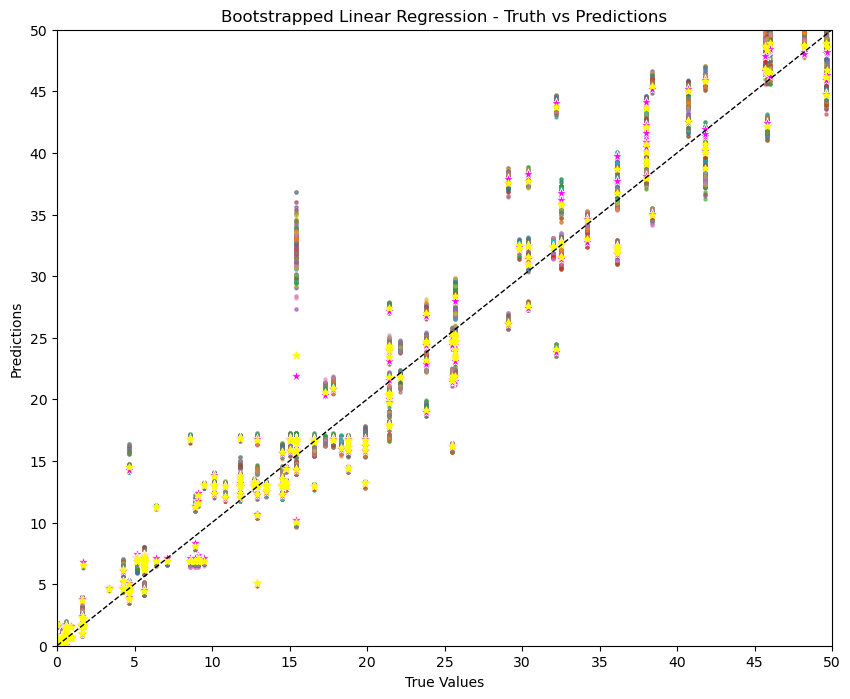

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "./Training/2024-3-19/predict/output2All.csv"
data = pd.read_csv(csv_path)

# Extracting input variables (columns 2-12) and target variable (column 7)
X = data.iloc[:, 1:12]
y = data["Truth"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Initialize the Linear Regression model
model = LinearRegression()

# Number of bootstrap iterations
num_iterations = 1000

# Lists to store coefficients and intercepts
coef_list = []
intercept_list = []
std_deviation_list = []

# Lists to store results
mse_list = []
rmse_list = []
mae_list = []
r2_list = []

# Plotting the results
plt.figure(figsize=(10, 8))

best_rmse = 1000000

for _ in range(num_iterations):
    # Set a different random seed for each iteration
    random_seed = np.random.randint(1, 1000)
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    # Train the model
    model.fit(X_train_iter, y_train_iter)

    # Append coefficients and intercept to lists
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)

    # Make predictions on the test set
    y_pred_iter = model.predict(X_test_iter)
    
    
    # Make predictions on the test set
    y_pred_iter = model.predict(X_test_iter)

    # Calculate the standard deviation of the predictions from the truth
    std_deviation_iter = np.std(y_test_iter - y_pred_iter)
    std_deviation_list.append(std_deviation_iter)

    # Plotting the results for each iteration
    plt.scatter(y_test_iter, y_pred_iter, s=5, alpha=0.5)
    
    
    # Evaluate the model
    mse_iter = mean_squared_error(y_test_iter, y_pred_iter)
    rmse_iter = np.sqrt(mse_iter)
    mae_iter = mean_absolute_error(y_test_iter, y_pred_iter)
    r2_iter = r2_score(y_test_iter, y_pred_iter)

    # Append results to lists
    mse_list.append(mse_iter)
    rmse_list.append(rmse_iter)
    mae_list.append(mae_iter)
    r2_list.append(r2_iter)
    
    if rmse_iter < best_rmse:
        best_rmse = rmse_iter
        best_model = model
        best_test = y_test_iter
        best_pred = y_pred_iter
        best_X = X_test_iter
        best_r2 = r2_iter
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=random_seed)
# Calculate mean coefficients and intercept
mean_coef = np.mean(coef_list, axis=0)
mean_intercept = np.mean(intercept_list)

# Print the mean coefficients and intercept
equation = f"y = {mean_coef[0]:.2f} * <0-0.5> + {mean_coef[1]:.2f} * <0.5-1> + {mean_coef[2]:.2f} * <1-2.5> + {mean_coef[3]:.2f} * <2.5-5> + {mean_coef[4]:.2f} * <5-10> + {mean_coef[5]:.2f} * <10-15> + {mean_coef[6]:.2f} * <15-21> + {mean_coef[7]:.2f} * <21-29> + {mean_coef[8]:.2f} * <29-37> + {mean_coef[9]:.2f} * <37-45> + {mean_coef[10]:.2f} * <45-55> + {mean_intercept:.2f}"
print("Equation of Mean of the bootstrapped regression:\n", equation)
mean_model = LinearRegression()
mean_model.coef_ = mean_coef
mean_model.intercept_ = mean_intercept
mean_pred = mean_model.predict(X_test)
mse_mean = mean_squared_error(y_test, mean_pred)
rmse_mean = np.sqrt(mse_mean)
r2_mean = r2_score(y_test, mean_pred)

print(f'\nRMSE: {rmse_mean}')
print(f'R2 Score: {r2_mean}')
print("\n-----------------------------------------------------\n")

equation = f"y = {best_model.coef_[0]:.2f} * <0-0.5> + {best_model.coef_[1]:.2f} * <0.5-1> + {best_model.coef_[2]:.2f} * <1-2.5> + {best_model.coef_[3]:.2f} * <2.5-5> + {best_model.coef_[4]:.2f} * <5-10> + {best_model.coef_[5]:.2f} * <10-15> + {best_model.coef_[6]:.2f} * <15-21> + {best_model.coef_[7]:.2f} * <21-29> + {best_model.coef_[8]:.2f} * <29-37> + {best_model.coef_[9]:.2f} * <37-45> + {best_model.coef_[10]:.2f} * <45-55> + {best_model.intercept_:.2f}"
print("Equation of Best Model from the bootstrapped regression:\n", equation)


best_pred = best_model.predict(X_test)
mse_best = mean_squared_error(y_test, best_pred)
rmse_best = np.sqrt(mse_best)
r2_mean = r2_score(y_test, best_pred)

plt.scatter(y_test, best_pred, s=64, alpha=1, marker="*", c="magenta", edgecolor="white", linewidth=0.6)
plt.scatter(y_test, mean_pred, s=24, alpha=1, marker="*", c="yellow")

print(f'\nRMSE: {rmse_best}')
print(f'R2 Score: {best_r2}')

print()

if rmse_mean < rmse_best:
    print("MEAN IS BETTER")

else:
    print("BEST IS BETTER")

# Plotting the ideal result line
plt.plot([0, 55], [0, 55], '--k', linewidth=1)

# Additional plot settings
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Bootstrapped Linear Regression - Truth vs Predictions")
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xticks(range(0, 51, 5))
plt.yticks(range(0, 51, 5))
plt.show()


### Proper Linear Regression


RMSE:2.0551167134473727

Linear Regression Equation: 
y = 61.34 * <0-0.5> + 61.57 * <0.5-1> + 62.48 * <1-2.5> + 65.53 * <2.5-5> + 67.76 * <5-10> + 73.91 * <10-15> + 77.63 * <15-21> + 85.64 * <21-29> + 93.29 * <29-37> + 99.40 * <37-45> + 114.32 * <45-55> + -60.90

                            WLS Regression Results                            
Dep. Variable:                  Truth   R-squared:                       0.975
Model:                            WLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2349.
Date:                Mon, 25 Mar 2024   Prob (F-statistic):               0.00
Time:                        12:54:52   Log-Likelihood:                -1416.2
No. Observations:                 662   AIC:                             2856.
Df Residuals:                     650   BIC:                             2910.
Df Model:                          11                                         
Covariance Type:        

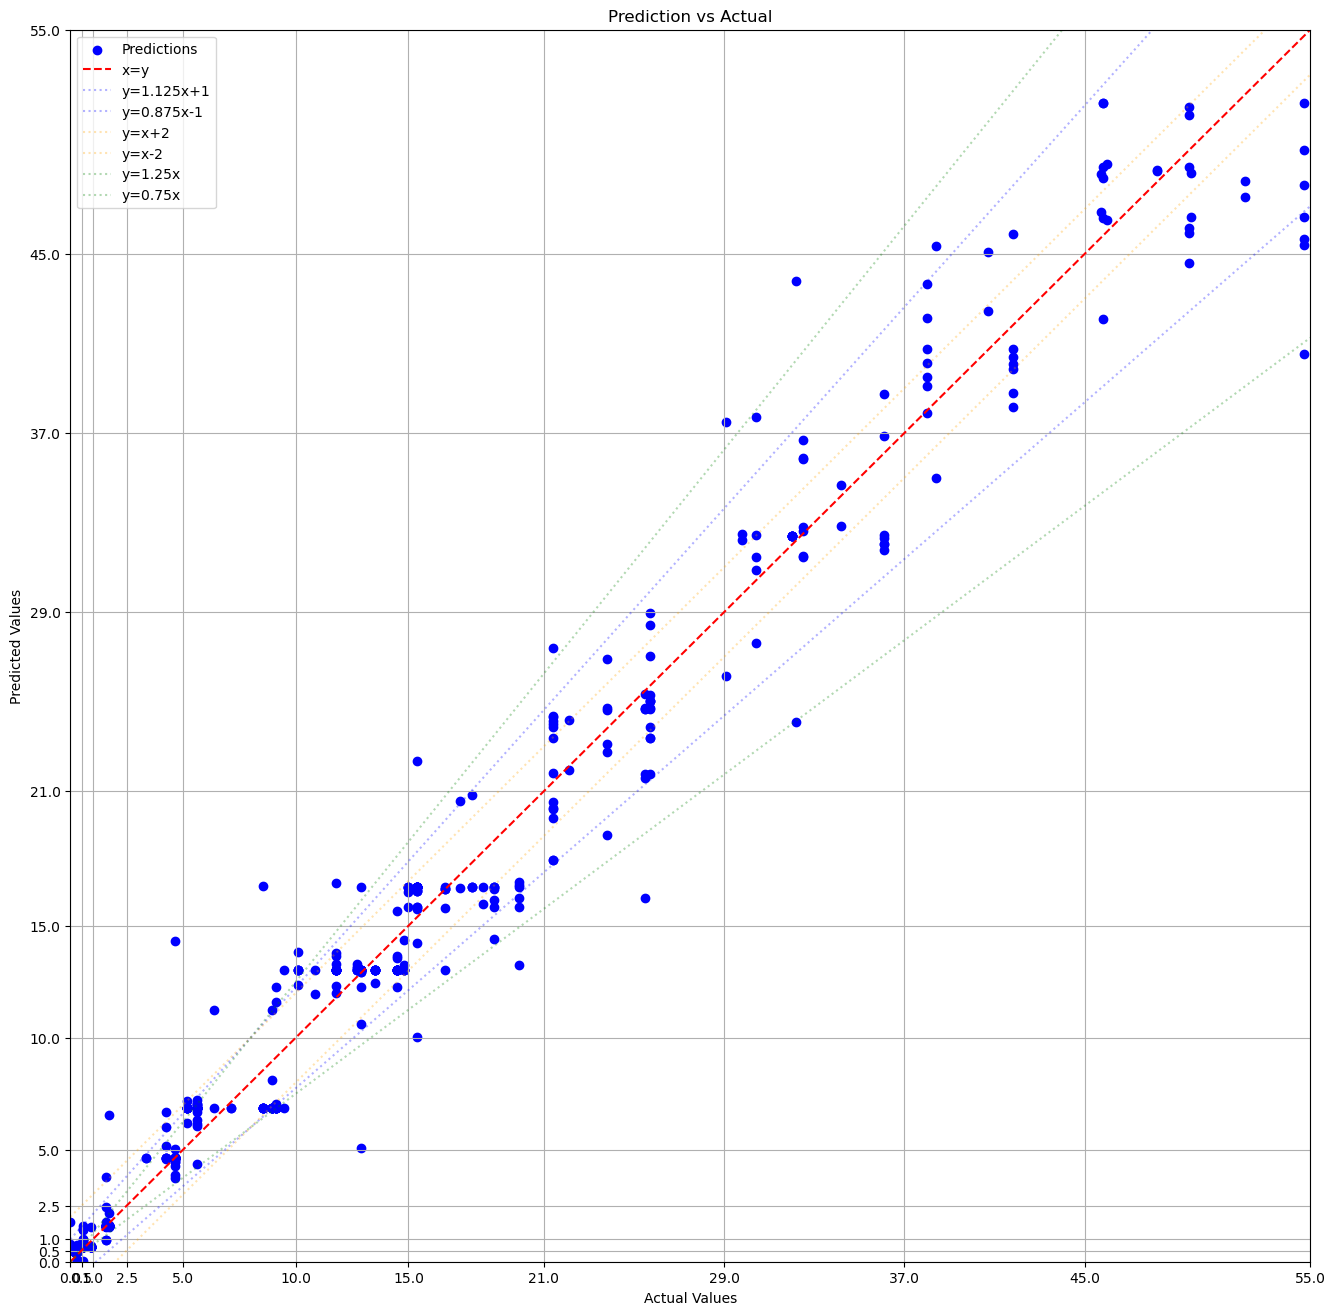

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

# Load the CSV file
csv_path = "./Training/2024-3-19/predict/output2All.csv"
data = pd.read_csv(csv_path)

# Extracting input variables (columns 2-12) and target variable (column 7)
X = data.iloc[:, 1:12]
y = data["Truth"]

X_pred = sm.add_constant(X)

model = sm.WLS(y, X_pred)
res = model.fit()
ypred = res.predict(X_pred)

rmse = rmse(y, ypred)
print(f'\nRMSE:{rmse}')


#-------- Printing Equation -----------
coefficients = res.params[1:]
intercept = res.params[0]

ranges = ["<0-0.5>", "<0.5-1>", "<1-2.5>", "<2.5-5>", "<5-10>", "<10-15>", "<15-21>", "<21-29>", "<29-37>", "<37-45>", "<45-55>"]

# Generate the equation string
equation = "y = "
for i, coef in enumerate(coefficients[:]): 
    equation += f"{coef:.2f} * {ranges[i]} + "
equation += f"{intercept:.2f}"

print(f'\nLinear Regression Equation: \n{equation}\n')
#--------------------------------------


print(res.summary())


# calculate % of predictions within [20% +- 1 FNU] and [ +- 2 FNU]
within_range_count = sum((ypred >= y*0.875 - 1) & (ypred <= y*1.125 + 1))
total_points = len(ypred)
percentage_within_range = (within_range_count / total_points) * 100
print(f"\n{percentage_within_range:.2f}% of estimates fall between y=1.125x+1 and y=0.875x-1  [25% +- 1FNU of true value]")

within_range_count = sum((ypred >= y -2) & (ypred <= y +2))
percentage_within_range = (within_range_count / total_points) * 100
print(f"{percentage_within_range:.2f}% of estimates fall between y=X+2 and y=X-2")

within_range_count = sum((ypred >= y*0.75) & (ypred <= y*1.25))
percentage_within_range = (within_range_count / total_points) * 100
print(f"{percentage_within_range:.2f}% of estimates fall within 50% of true value\n")


#--------------------------Plotting------------------------------------
plt.figure(figsize=(16, 16))
plt.scatter(y, ypred, color='blue', label='Predictions')

# plot ideal line
x_values = np.linspace(0, 55, 100)
plt.plot(x_values, x_values, color='red', linestyle='--', label='x=y')

# plot lines for deviation
plt.plot(x_values, x_values*1.125 + 1, color='blue', linestyle=':', alpha=0.3, label='y=1.125x+1')
plt.plot(x_values, x_values*0.875 - 1, color='blue', linestyle=':', alpha=0.3, label='y=0.875x-1')
plt.plot(x_values, x_values + 2, color='orange', linestyle=':', alpha=0.3, label='y=x+2')
plt.plot(x_values, x_values - 2, color='orange', linestyle=':', alpha=0.3, label='y=x-2')
plt.plot(x_values, x_values*1.25, color='green', linestyle=':', alpha=0.3, label='y=1.25x')
plt.plot(x_values, x_values*0.75, color='green', linestyle=':', alpha=0.3, label='y=0.75x')

plt.xticks([0, 0.5, 1, 2.5, 5,10,15,21,29,37,45,55])
plt.yticks([0, 0.5, 1, 2.5, 5,10,15,21,29,37,45,55])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction vs Actual')
plt.xlim(0, 55)
plt.ylim(0, 55)

plt.legend()
plt.grid(True)
plt.show()



### Bagged Quantile Regression

/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +
/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (

Mean Squared Error: 4.72082224639154 
Root Mean Squared Error: 2.153901131031577
R2 Score: 0.9721358132406729
Equation of the bootstrapped quantile regression: y = -1.60 * <00-0.49> + -1.25 * <00.5-0.99> + -0.20 * <01-2.49> + 2.85 * <02.5-4.99> + 3.83 * <05-9.99> + 11.10 * <10-14.99> + 13.85 * <15-20.99> + 23.45 * <21-28.99> + 30.21 * <29-36.99> + 36.42 * <37-44.99> + 50.47 * <45-55> + 1.80


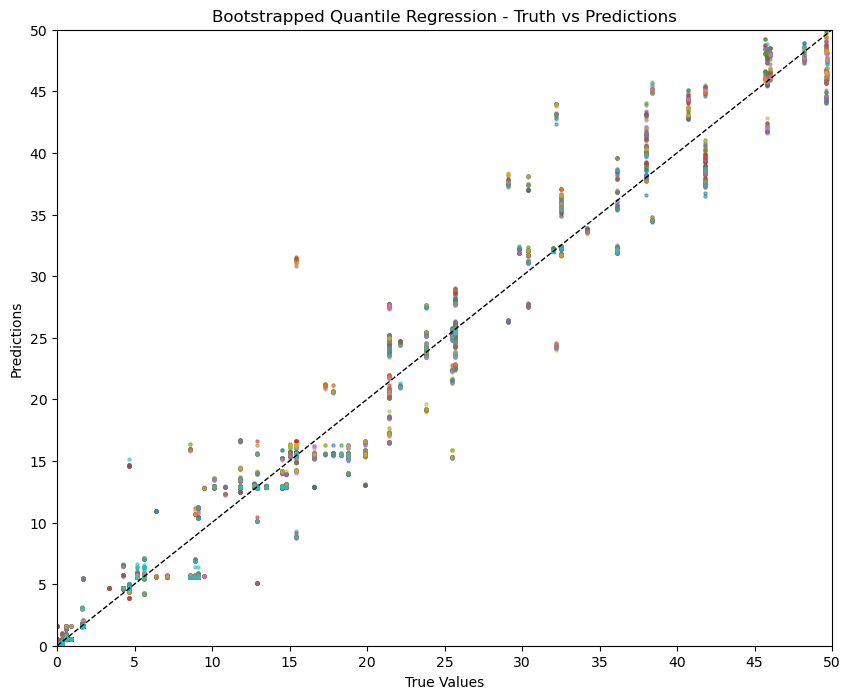

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Load the CSV file
csv_path = "./Training/2024-3-19/predict/output2All.csv"
data = pd.read_csv(csv_path)

# Extracting input variables (columns 2-12) and target variable (column 7)
X = data.iloc[:, 1:12]
y = data["Truth"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Number of bootstrap iterations
num_iterations = 100

# Lists to store results
mse_list = []
rmse_list = []
mae_list = []
r2_list = []
std_deviation_list = []
coef_list = []
intercept_list = []

# Plotting the results
plt.figure(figsize=(10, 8))

for _ in range(num_iterations):
    # Set a different random seed for each iteration
    random_seed = np.random.randint(1, 1000)
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    # Initialize the Quantile Regression model
    model = sm.QuantReg(y_train_iter, sm.add_constant(X_train_iter))

    # Fit the model
    result = model.fit(q=0.5)  # You can adjust the quantile as needed

    # Make predictions on the test set
    y_pred_iter = result.predict(sm.add_constant(X_test_iter))

    # Plotting the results for each iteration
    plt.scatter(y_test_iter, y_pred_iter, s=5, alpha=0.5)

    # Calculate the standard deviation of predictions from the truth
    std_deviation_iter = np.std(y_test_iter - y_pred_iter)
    std_deviation_list.append(std_deviation_iter)

    # Evaluate the model
    mse_iter = mean_squared_error(y_test_iter, y_pred_iter)
    rmse_iter = np.sqrt(mse_iter)
    mae_iter = mean_absolute_error(y_test_iter, y_pred_iter)
    r2_iter = r2_score(y_test_iter, y_pred_iter)

    # Append results to lists
    mse_list.append(mse_iter)
    rmse_list.append(rmse_iter)
    mae_list.append(mae_iter)
    r2_list.append(r2_iter)

    # Append coefficients and intercept to lists
    coef_list.append(result.params[1:])  # excluding the intercept
    intercept_list.append(result.params[0])

# Calculate mean and standard deviation of the results
mse_mean = np.mean(mse_list)
rmse_mean = np.mean(rmse_list)
mae_mean = np.mean(mae_list)
r2_mean = np.mean(r2_list)



# Calculate mean standard deviation of predictions from the truth
std_deviation_mean = np.mean(std_deviation_list)

# Print the mean and standard deviation of the results
print(f'Mean Squared Error: {mse_mean} ')
print(f'Root Mean Squared Error: {rmse_mean}')
print(f'R2 Score: {r2_mean}')

# Calculate mean coefficients and intercept
mean_coef = np.mean(coef_list, axis=0)
mean_intercept = np.mean(intercept_list)

# Print the mean coefficients and intercept
equation = "y = "
for i, coef in enumerate(mean_coef):
    equation += f"{coef:.2f} * <{X.columns[i]}> + "
equation += f"{mean_intercept:.2f}"
print("Equation of the bootstrapped quantile regression:", equation)

# Additional plot settings
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Bootstrapped Quantile Regression - Truth vs Predictions")
plt.plot([0, 50], [0, 50], '--k', linewidth=1)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xticks(range(0, 51, 5))
plt.yticks(range(0, 51, 5))
plt.show()


### Bootstrapped Ridge Regression

Mean Squared Error: 9.250291321869536 ± 3.446907988624825
Root Mean Squared Error: 2.986841179695122 ± 0.5736471817650534
Mean Absolute Error: 1.4065016179682572 ± 0.24406571744237965
R2 Score: 0.9142754842406449 ± 0.020289477296036456
Mean Standard Deviation of Predictions from Truth: 2.9687848745074263
Equation of the bootstrapped Ridge regression: y = 10.32 + -9.90 * <0-0.99> + -8.65 * <1-4> + -3.98 * <5-9> + 2.96 * <10-24> + 24.93 * <25-55> 


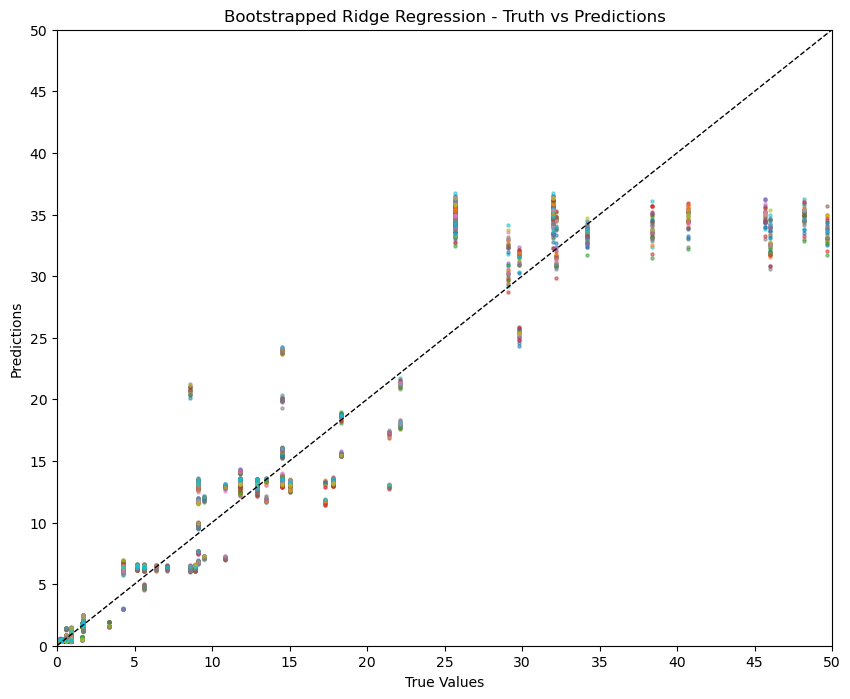

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load the CSV file
csv_path = "./Training/2024-1-30/predict7/output2All.csv"
data = pd.read_csv(csv_path)

# Extracting input variables (columns 2-6) and target variable (column 7)
X = data.iloc[:, 1:6]
y = data["Truth"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

# Number of bootstrap iterations
num_iterations = 100

# Lists to store results
mse_list = []
rmse_list = []
mae_list = []
r2_list = []
std_deviation_list = []
coef_list = []
intercept_list = []

# Plotting the results
plt.figure(figsize=(10, 8))

for _ in range(num_iterations):
    # Set a different random seed for each iteration
    random_seed = np.random.randint(1, 1000)
    X_train_iter, X_test_iter, y_train_iter, y_test_iter = train_test_split(X, y, test_size=0.2, random_state=random_seed)

    # Initialize the Ridge Regression model
    alpha = 0.010  # You can adjust the regularization strength
    model = Ridge(alpha=alpha)

    # Fit the model
    model.fit(X_train_iter, y_train_iter)

    # Make predictions on the test set
    y_pred_iter = model.predict(X_test_iter)

    # Plotting the results for each iteration
    plt.scatter(y_test_iter, y_pred_iter, s=5, alpha=0.5)

    # Calculate the standard deviation of predictions from the truth
    std_deviation_iter = np.std(y_test_iter - y_pred_iter)
    std_deviation_list.append(std_deviation_iter)

    # Evaluate the model
    mse_iter = mean_squared_error(y_test_iter, y_pred_iter)
    rmse_iter = np.sqrt(mse_iter)
    mae_iter = mean_absolute_error(y_test_iter, y_pred_iter)
    r2_iter = r2_score(y_test_iter, y_pred_iter)

    # Append results to lists
    mse_list.append(mse_iter)
    rmse_list.append(rmse_iter)
    mae_list.append(mae_iter)
    r2_list.append(r2_iter)

    # Append coefficients and intercept to lists
    coef_list.append(model.coef_)
    intercept_list.append(model.intercept_)

# Calculate mean and standard deviation of the results
mse_mean = np.mean(mse_list)
rmse_mean = np.mean(rmse_list)
mae_mean = np.mean(mae_list)
r2_mean = np.mean(r2_list)

mse_std = np.std(mse_list)
rmse_std = np.std(rmse_list)
mae_std = np.std(mae_list)
r2_std = np.std(r2_list)

# Calculate mean standard deviation of predictions from the truth
std_deviation_mean = np.mean(std_deviation_list)

# Print the mean and standard deviation of the results
print(f'Mean Squared Error: {mse_mean} ± {mse_std}')
print(f'Root Mean Squared Error: {rmse_mean} ± {rmse_std}')
print(f'Mean Absolute Error: {mae_mean} ± {mae_std}')
print(f'R2 Score: {r2_mean} ± {r2_std}')
print(f"Mean Standard Deviation of Predictions from Truth: {std_deviation_mean}")

# Calculate mean coefficients and intercept
mean_coef = np.mean(coef_list, axis=0)
mean_intercept = np.mean(intercept_list)

# Print the mean coefficients and intercept
equation = f"y = {mean_intercept:.2f} + "
for i, coef in enumerate(mean_coef):
    equation += f"{coef:.2f} * <{X.columns[i]}> + "
equation = equation[:-2]  # Remove the trailing '+'
print("Equation of the bootstrapped Ridge regression:", equation)

# Additional plot settings
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Bootstrapped Ridge Regression - Truth vs Predictions")
plt.plot([0, 50], [0, 50], '--k', linewidth=1)
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.xticks(range(0, 51, 5))
plt.yticks(range(0, 51, 5))
plt.show()


### Inference

In [18]:
# Inference
!yolo task=classify mode=predict model="./Training/2023-10-8/train/weights/best.pt" conf=0.5 source="./Datasets/With Secchi/_Processed/val/**/*" project="./Training/2023-10-8"

WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.cfg' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.cfg' instead.
Ultralytics YOLOv8.0.138 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLOv8l-cls summary (fused): 133 layers, 36190981 parameters, 0 gradients

/home/twilight/anaconda3/envs/USDA2023/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,
image 1/8 /home/twilight/Honors Research Project/AI_Turbidity_Honors2023-4/Datasets/With Secchi/_Processed/val/0-10/P1010004.JPG: 320x320 0-10 1.00, 22-32 0.00, 11-21 0.00, 33-43 0.00, 44-55 0.00, 3.4ms
image 2/8 /home/tw

# Export to ONNX

In [6]:
#!yolo export model=path/to/best.pt format=onnx  # export custom trained model
!yolo export model="./Training/2024-3-19/TUNING/tune/weights/best.pt" format=onnx simplify=True device=0  # export custom trained model

Ultralytics YOLOv8.1.8 🚀 Python-3.11.4 torch-2.0.1 CUDA:0 (NVIDIA GeForce RTX 4080, 16376MiB)
YOLOv8l-cls summary (fused): 133 layers, 36198667 parameters, 0 gradients
/home/twilight/anaconda3/envs/Turbidity/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,

PyTorch: starting from 'Training/2024-3-19/TUNING/tune/weights/best.pt' with input shape (1, 3, 320, 320) BCHW and output shape(s) (1, 11) (69.2 MB)

ONNX: starting export with onnx 1.15.0 opset 17...
================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 1.8s, saved as 'Training/2024-